In [8]:
%matplotlib inline

In [9]:
!kim-api-collections-management install user SW_StillingerWeber_1985_Si__MO_405512056662_005

Item 'SW_StillingerWeber_1985_Si__MO_405512056662_005' already installed in collection 'user'.

Success!




# MCMC sampling

In this example, we demonstrate how to perform uncertainty quantification (UQ) using
parallel tempered MCMC (PTMCMC). We use a Stillinger-Weber (SW) potential for silicon
that is archived in OpenKIM_.

For simplicity, we only set the energy-scaling parameters, i.e., ``A`` and ``lambda`` as
the tunable parameters. Furthermore, these parameters are physically constrained to be
positive, thus we will work in log parameterization, i.e. ``log(A)`` and ``log(lambda)``.
These parameters will be calibrated to energies and forces of a small dataset,
consisting of 4 compressed and stretched configurations of diamond silicon structure.


To start, let's first install the SW model::

   $ kim-api-collections-management install user SW_StillingerWeber_1985_Si__MO_405512056662_006

.. seealso::
   This installs the model and its driver into the ``User Collection``. See
   `install_model` for more information about installing KIM models.



In [1]:
from multiprocessing import Pool

import numpy as np
from corner import corner

from kliff.ase.calculators import Calculator
from kliff.dataset import Dataset
from kliff.dataset.weight import MagnitudeInverseWeight
from kliff.ase.loss import Loss
from kliff.models import KIMModel
from kliff.models.parameter_transform import LogParameterTransform
from kliff.uq import MCMC, autocorr, mser, rhat
from kliff.utils import download_dataset

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Before running MCMC, we need to define a loss function and train the model. More detail
information about this step can be found in `tut_kim_sw` and
`tut_params_transform`.



In [2]:
# Instantiate a transformation class to do the log parameter transform
param_names = ["A", "lambda"]
params_transform = LogParameterTransform(param_names)

# Create the model
model = KIMModel(
    model_name="SW_StillingerWeber_1985_Si__MO_405512056662_005",
    params_transform=params_transform,
)

# Set the tunable parameters and the initial guess
opt_params = {
    "A": [["default", -8.0, 8.0]],
    "lambda": [["default", -8.0, 8.0]],
}

model.set_opt_params(**opt_params)
model.echo_opt_params()

# Get the dataset and set the weights
dataset_path = download_dataset(dataset_name="Si_training_set_4_configs")
# Instantiate the weight class
weight = MagnitudeInverseWeight(
    weight_params={
        "energy_weight_params": [0.0, 0.1],
        "forces_weight_params": [0.0, 0.1],
    }
)
# Read the dataset and compute the weight
tset = Dataset(dataset_path, weight=weight)
configs = tset.get_configs()

# Create calculator
calc = Calculator(model)
ca = calc.create(configs)

# Instantiate the loss function
residual_data = {"normalize_by_natoms": False}
loss = Loss(calc, residual_data=residual_data)

# Train the model
loss.minimize(method="L-BFGS-B", options={"disp": True})
model.echo_opt_params()

2023-04-06 16:06:12.016 | INFO     | kliff.dataset.dataset:_read:687 - 4 configurations read from /home/openkim/cwd/Si_training_set_4_configs
2023-04-06 16:06:12.019 | INFO     | kliff.ase.calculators.calculator:create:107 - Create calculator for 4 configurations.
2023-04-06 16:06:12.020 | INFO     | kliff.ase.loss:minimize:314 - Start minimization using method: L-BFGS-B.
2023-04-06 16:06:12.020 | INFO     | kliff.ase.loss:_scipy_optimize:433 - Running in serial mode.
2023-04-06 16:06:12.091 | INFO     | kliff.ase.loss:minimize:316 - Finish minimization using method: L-BFGS-B.


#================================================================================
# Model parameters that are optimized.
# Note that the parameters are in the transformed space if 
# `params_transform` is provided when instantiating the model.
#================================================================================

A 1
  2.7268620056558381e+00  -8.0000000000000000e+00   8.0000000000000000e+00 

lambda 1
  3.8184197679684773e+00  -8.0000000000000000e+00   8.0000000000000000e+00 


#================================================================================
# Model parameters that are optimized.
# Note that the parameters are in the transformed space if 
# `params_transform` is provided when instantiating the model.
#================================================================================

A 1
  2.7269268430316806e+00  -8.0000000000000000e+00   8.0000000000000000e+00 

lambda 1
  3.8183682461394426e+00  -8.0000000000000000e+00   8.0000000000000000e+00 




'#================================================================================\n# Model parameters that are optimized.\n# Note that the parameters are in the transformed space if \n# `params_transform` is provided when instantiating the model.\n#================================================================================\n\nA 1\n  2.7269268430316806e+00  -8.0000000000000000e+00   8.0000000000000000e+00 \n\nlambda 1\n  3.8183682461394426e+00  -8.0000000000000000e+00   8.0000000000000000e+00 \n\n'

To perform MCMC simulation, we use :class:`~kliff.uq.MCMC`.This class interfaces with
ptemcee_ Python package to run PTMCMC, which utilizes the affine invariance property
of MCMC sampling. We simulate MCMC sampling at several different temperatures to
explore the effect of the scale of bias and overall error bars.



In [3]:
# Define some variables that correspond to the dimensionality of the problem
ntemps = 4  # Number of temperatures to simulate
ndim = calc.get_num_opt_params()  # Number of parameters
nwalkers = 2 * ndim  # Number of parallel walkers to simulate

We start by instantiating :class:`~kliff.uq.MCMC`. This requires :class:`~kliff.ase.loss.Loss`
instance to construct the likelihood function. Additionally, we can specify the prior
(or log-prior to be more precise) via the ``logprior_fn`` argument, with the default
option be a uniform prior that is bounded over a finite range that we specify via the
``logprior_args`` argument.

<div class="alert alert-info"><h4>Note</h4><p>When user uses the default uniform prior but doesn't specify the bounds, then the
   sampler will retrieve the bounds from the model
   (see :meth:`~kliff.models.KIMModel.set_opt_params`). Note that an error will be
   raised when the uniform prior extends to infinity in any parameter direction.</p></div>

To specify the sampling temperatures to use, we can use the arguments ``ntemps`` and
``Tmax_ratio`` to set how many temperatures to simulate and the ratio of the highest
temperature to the natural temperature $T_0$, respectively. The default values of
``ntemps`` and ``Tmax_ratio`` are 10 and 1.0, respectively. Then, an internal function
will create a list of logarithmically spaced points from $T = 1.0$ to
$T = T_{\text{max\_ratio}} \times T_0$. Alternatively, we can also give a list of
the temperatures via ``Tladder`` argument, which will overwrites ``ntemps`` and
``Tmax_ratio``.

<div class="alert alert-info"><h4>Note</h4><p>It has been shown that including temperatures higher than $T_0$ helps the
   convergence of walkers sampled at $T_0$.</p></div>

The sampling processes can be parallelized by specifying the pool. Note that the pool
needs to be declared after instantiating :class:`~kliff.uq.MCMC`, since the posterior
function is defined during this process.



In [4]:
# Set the boundaries of the uniform prior
bounds = np.tile([-8.0, 8.0], (ndim, 1))

# It is a good practice to specify the random seed to use in the calculation to generate
# a reproducible simulation.
seed = 1717
np.random.seed(seed)

# Create a sampler
sampler = MCMC(
    loss,
    ntemps=ntemps,
    logprior_args=(bounds,),
    random=np.random.RandomState(seed),
)
# Declare a pool to use parallelization
sampler.pool = Pool(nwalkers)

<div class="alert alert-info"><h4>Note</h4><p>As a default, the algorithm will set the number of walkers for each sampling
   temperature to be twice the number of parameters, but we can also specify it via
   the ``nwalkers`` argument.</p></div>

To run the MCMC sampling, we use :meth:`~kliff.uq.MCMC.run_mcmc`. This function requires
us to provide initial states $p_0$ for each temperature and walker. We also need
to specify the number of steps or iterations to take.

<div class="alert alert-info"><h4>Note</h4><p>The initial states $p_0$ need to be an array with shape ``(K, L, N,)``, where
   ``K``, ``L``, and ``N`` are the number of temperatures, walkers, and parameters,
   respectively.</p></div>



In [5]:
# Initial starting point. This should be provided by the user.
p0 = np.empty((ntemps, nwalkers, ndim))
for ii, bound in enumerate(bounds):
    p0[:, :, ii] = np.random.uniform(*bound, (4, 4))

# Run MCMC
sampler.run_mcmc(p0, 5000)
sampler.pool.close()

# Retrieve the chain
chain = sampler.chain

The resulting chains still need to be processed. First, we need to discard the first few
iterations in the beginning of each chain as a burn-in time. This is similar to the
equilibration time in a molecular dynamic simulation before we can start the
measurement. KLIFF provides a function to estimate the burn-in time, based on the
Marginal Standard Error Rule (MSER). This can be accessed via
:func:`~kliff.uq.mcmc_utils.mser`.



In [6]:
# Estimate equilibration time using MSER for each temperature, walker, and dimension.
mser_array = np.empty((ntemps, nwalkers, ndim))
for tidx in range(ntemps):
    for widx in range(nwalkers):
        for pidx in range(ndim):
            mser_array[tidx, widx, pidx] = mser(
                chain[tidx, widx, :, pidx], dmin=0, dstep=10, dmax=-1
            )

burnin = int(np.max(mser_array))
print(f"Estimated burn-in time: {burnin}")

Estimated burn-in time: 750


<div class="alert alert-info"><h4>Note</h4><p>:func:`~kliff.uq.mcmc_utils.mser` only compute the estimation of the burn-in time for
   one single temperature, walker, and parameter. Thus, we need to calculate the burn-in
   time for each temperature, walker, and parameter separately.</p></div>

After discarding the first few iterations as the burn-in time, we only want to keep
every $\tau$-th iteration from the remaining chain, where $\tau$ is the
autocorrelation length, to ensure uncorrelated samples.
This calculation can be done using :func:`~kliff.uq.mcmc_utils.autocorr`.



In [7]:
# Estimate the autocorrelation length for each temperature
chain_no_burnin = chain[:, :, burnin:]

acorr_array = np.empty((ntemps, nwalkers, ndim))
for tidx in range(ntemps):
    acorr_array[tidx] = autocorr(chain_no_burnin[tidx], c=1, quiet=True)

thin = int(np.ceil(np.max(acorr_array)))
print(f"Estimated autocorrelation length: {thin}")

Estimated autocorrelation length: 14


<div class="alert alert-info"><h4>Note</h4><p>:func:`~kliff.uq.mcmc_utils.acorr` is a wrapper for emcee.autocorr.integrated_time_,
   As such, the shape of the input array for this function needs to be ``(L, M, N,)``,
   where ``L``, ``M``, and ``N`` are the number of walkers, steps, and parameters,
   respectively. This also implies that we need to perform the calculation for each
   temperature separately.</p></div>

Finally, after obtaining the independent samples, we need to assess whether the
resulting samples have converged to a stationary distribution, and thus a good
representation of the actual posterior. This is done by computing the potential scale
reduction factor (PSRF), denoted by $\hat{R}^p$. The value of $\hat{R}^p$
declines to 1 as the number of iterations goes to infinity. A common threshold is about
1.1, but higher threshold has also been used.



In [8]:
# Assess the convergence for each temperature
samples = chain_no_burnin[:, :, ::thin]

threshold = 1.1  # Threshold for rhat
rhat_array = np.empty(ntemps)
for tidx in range(ntemps):
    rhat_array[tidx] = rhat(samples[tidx])

print(f"$\hat{{r}}^p$ values: {rhat_array}")

$\hat{r}^p$ values: [1.0991534  1.07341457 1.07658106 1.02770675]


<div class="alert alert-info"><h4>Note</h4><p>:func:`~kliff.uq.mcmc_utils.rhat` only computes the PSRF for one temperature, so that
   the calculation needs to be carried on for each temperature separately.</p></div>

Notice that in this case, $\hat{R}^p < 1.1$ for all temperatures. When this
criteria is not satisfied, then the sampling process should be continued. Note that
some sampling temperatures might converge at slower rates compared to the others.

After obtaining the independent samples from the MCMC sampling, the uncertainty of the
parameters can be obtained by observing the distribution of the samples. As an example,
we will use corner_ Python package to present the MCMC result at sampling
temperature 1.0 as a corner plot.



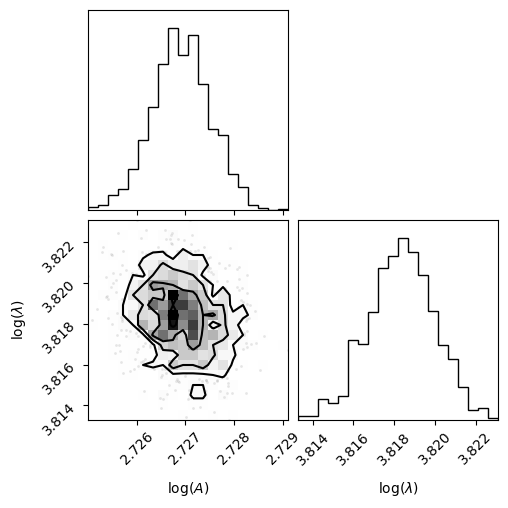

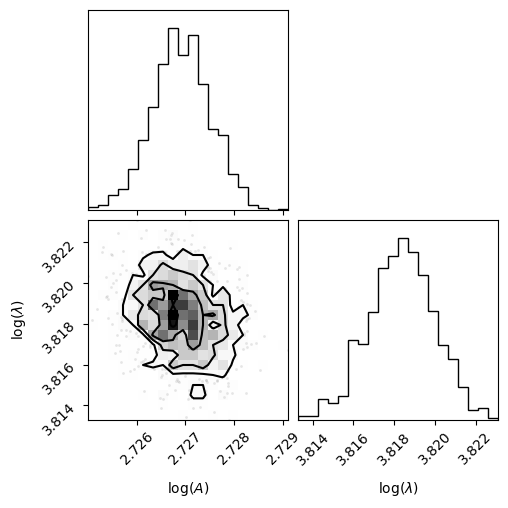

In [9]:
# Plot samples at T=1.0
corner(samples[0].reshape((-1, ndim)), labels=[r"$\log(A)$", r"$\log(\lambda)$"])

<div class="alert alert-info"><h4>Note</h4><p>As an alternative, KLIFF also provides a wrapper to emcee_. This can be accessed by
   setting ``sampler="emcee"`` when instantiating :class:`~kliff.uq.MCMC`. For further
   documentation, see :class:`~kliff.uq.EmceeSampler`.</p></div>


